In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import syft as sy
from syft.frameworks.torch.fl import utils
#from syft.frameworks.torch.federated import utils
from syft.frameworks.torch.fl import FederatedDataset, FederatedDataLoader, BaseDataset
from torchvision import transforms
from torchvision import datasets

In [ ]:
!pip install syft==0.2.3a1

     |████████████████████████████████| 332 kB 5.1 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 1.8 MB 46.4 MB/s 
     |████████████████████████████████| 753.4 MB 6.4 kB/s 
     |████████████████████████████████| 2.1 MB 39.1 MB/s 
     |████████████████████████████████| 111 kB 51.1 MB/s 
     |████████████████████████████████| 535 kB 65.0 MB/s 
     |████████████████████████████████| 4.0 MB 57.3 MB/s 
     |████████████████████████████████| 66 kB 3.7 MB/s 
     |████████████████████████████████| 55 kB 3.7 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
  Created wheel for phe: filename=phe-1.4.0-py2.py3-none-any.whl size=37362 sha256=9f1d6aec167ef57cdda4b888a5c9c74e59c75d90ccf919048ce397a0a4617712
  Stored in directory: /root/.cache/pip/wheels/bb/ac/9b/b07a04fe6bb1418ab4ee06d6652757aef848b80363c4dac507
  Created wheel for zstd: filename=zstd-1.5.0.4-cp37-cp37m-linux_x86_64.whl size=1673421 sha256=bcbdb8bfc6f09abb1cc

In [ ]:
!pip install syft_proto=="0.1.1a1.post17"

     |████████████████████████████████| 40 kB 3.0 MB/s 
  Attempting uninstall: syft-proto
    Found existing installation: syft-proto 0.5.3
    Uninstalling syft-proto-0.5.3:
      Successfully uninstalled syft-proto-0.5.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/lab4/chest')

Mounted at /content/drive


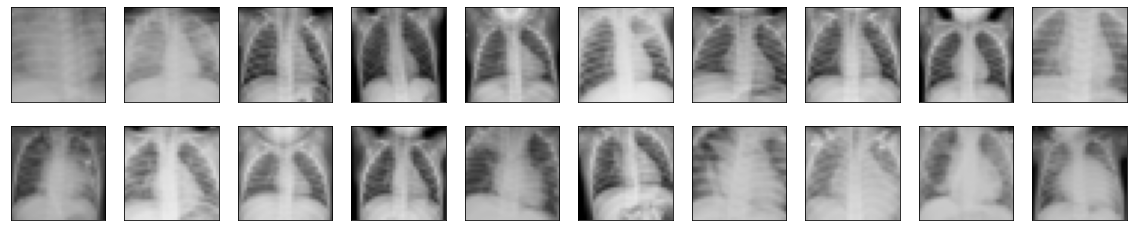

In [ ]:
transforms_image = transforms.Compose([transforms.Resize(32),
                                     transforms.CenterCrop(32),
                                     transforms.ToTensor()])
train_xray = torch.utils.data.DataLoader(datasets.ImageFolder('train',transform=transforms_image),
                                                        batch_size=20, shuffle=True)
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(train_xray)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])


In [ ]:
hook = sy.TorchHook(torch)

In [ ]:
hook = sy.TorchHook(torch)
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
c = sy.VirtualWorker(hook, id="c")
d = sy.VirtualWorker(hook, id="d")
e = sy.VirtualWorker(hook, id="e")
f = sy.VirtualWorker(hook, id="f")

In [ ]:
image_transforms = {'train': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])]),
                   'valid': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])]),
                   'test': transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])
                  }

loaders = {'train': torch.utils.data.DataLoader(datasets.ImageFolder('train', 
                                                                            transform=image_transforms['train']),
                                                        batch_size=128, shuffle=True),                    
                   'valid': torch.utils.data.DataLoader(datasets.ImageFolder('val', 
                                                                             transform=image_transforms['valid']),
                                                        batch_size=128, shuffle=True), 
                   'test': torch.utils.data.DataLoader(datasets.ImageFolder('test', 
                                                                            transform=image_transforms['test']),
                                                        batch_size=128, shuffle=True)}

In [ ]:
import math
import logging

import torch
from torch.utils.data import Dataset

logger = logging.getLogger(__name__)
def dataset_federate(dataset, workers):
    """
    Add a method to easily transform a torch.Dataset or a sy.BaseDataset
    into a sy.FederatedDataset. The dataset given is split in len(workers)
    part and sent to each workers
    """
    logger.info("Scanning and sending data to {}...".format(", ".join([w.id for w in workers])))

    # take ceil to have exactly len(workers) sets after splitting
    data_size = math.ceil(len(dataset) / len(workers))

    # Fix for old versions of torchvision
#     if not hasattr(dataset, "data"):
#         if hasattr(dataset, "train_data"):
#             dataset.data = dataset.train_data
#         elif hasattr(dataset, "test_data"):
#             dataset.data = dataset.test_data
#         else:
#             raise AttributeError("Could not find inputs in dataset")
#     if not hasattr(dataset, "targets"):
#         if hasattr(dataset, "train_labels"):
#             dataset.targets = dataset.train_labels
#         elif hasattr(dataset, "test_labels"):
#             dataset.targets = dataset.test_labels
#         else:
#             raise AttributeError("Could not find targets in dataset")

    datasets = []
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=data_size, drop_last=True)
    for dataset_idx, (data, targets) in enumerate(data_loader):
        worker = workers[dataset_idx % len(workers)]
        logger.debug("Sending data to worker %s", worker.id)
        data = data.send(worker)
        targets = targets.send(worker)
        datasets.append(BaseDataset(data, targets))  # .send(worker)

    logger.debug("Done!")
    return FederatedDataset(datasets)

datasets.ImageFolder.federate = dataset_federate

In [ ]:
federated_train_loader = sy.FederatedDataLoader(datasets.ImageFolder('train', 
                                                transform=image_transforms['train']).federate((bob, alice,c,d,e,f)),
                                                batch_size=128, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(140450, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [ ]:
model = Net()

In [ ]:
print(model)

Net(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=140450, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0005)

In [ ]:
for epoch in range(10):
    model.train()
    for batch_idx, (data, target) in enumerate(federated_train_loader):
        model.send(data.location)
        output = model(data)
        data, target = data.to('cpu'), target.to('cpu')
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.get()
        if batch_idx % 30 == 0:
            loss = loss.get() 
            print('Train Epoch: {} Loss: {:.6f}'.format(
                epoch, loss.item()))
    model.eval()
    print('Epoch: ', epoch)
    total_correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(loaders['test']):
        output = model(data)
        loss = criterion(output, target)
        print('Loss: ', loss.item())
        max_arg_output = torch.argmax(output, dim=1)
        total_correct += int(torch.sum(max_arg_output == target))
        total += data.shape[0]
    print('Testing data accuracy: {:.0%}'.format(total_correct/total))
   # if total_correct/total > 0.5:
    #    torch.save(model.state_dict(), 'pt_federated/XRP_' + str(time.strftime("%Y%m%d_%H%M%S"))+'.pt')

Train Epoch: 0 Loss: 2.286263
Train Epoch: 0 Loss: 0.434782
Epoch:  0
Loss:  1.3685210943222046
Loss:  1.2511875629425049
Loss:  1.2870839834213257
Loss:  1.2621797323226929
Loss:  1.3093440532684326
Testing data accuracy: 62%
Train Epoch: 1 Loss: 2.952427
Train Epoch: 1 Loss: 0.139709
Epoch:  1
Loss:  1.4568040370941162
Loss:  1.648262619972229
Loss:  1.4608319997787476
Loss:  1.189681053161621
Loss:  1.2237813472747803
Testing data accuracy: 62%
Train Epoch: 2 Loss: 3.318768
Train Epoch: 2 Loss: 0.124095
Epoch:  2
Loss:  1.3724385499954224
Loss:  1.2409048080444336
Loss:  1.5825672149658203
Loss:  1.312330961227417
Loss:  1.5269601345062256
Testing data accuracy: 62%
Train Epoch: 3 Loss: 3.174000
Train Epoch: 3 Loss: 0.125557
Epoch:  3
Loss:  1.4769095182418823
Loss:  1.4549975395202637
Loss:  1.3733490705490112
Loss:  1.458787441253662
Loss:  1.2482936382293701
Testing data accuracy: 62%
Train Epoch: 4 Loss: 2.949314
Train Epoch: 4 Loss: 0.097302
Epoch:  4
Loss:  1.3184449672698975
